In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import sleep
from IPython.display import clear_output
from math import ceil,floor

%matplotlib inline

In [2]:
class Agent:

    def __init__(self, game, policy=None, discount_factor=0.1, learning_rate=0.1, exploitation_rate=0.9):

        """

        :param game:
        :param policy:
        :param discount_factor:
        :param learning_rate:
        :param ratio_explotacion:
        """

        # Build policy table
        if policy is not None:
            self._q_table = policy
        else:
            position = list(game.positions_space.shape)
            position.append(len(game.action_space))
            self._q_table = np.zeros(position)

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.exploitation_rate = exploitation_rate

    def get_next_step(self, state, game):
        """
        Select next best action (max) with the information given by the state. Some times, it generates a random
        move (up or down) to explore new possible combinations

        :param state: current state (agent_position, ball_x, ball_y)
        :param game: environment
        :return:
        """
        # Random step for exploring
        next_step = np.random.choice(list(game.action_space))

        # np.random.uniform returns a number between [0,1]
        if np.random.uniform() <= self.exploitation_rate:
            # in the current state we select the max value between 2 possible actions (Up, Down)
            idx_action = np.random.choice(np.flatnonzero(
                self._q_table[state[0], state[1], state[2]] == self._q_table[state[0], state[1], state[2]].max()
            ))
            next_step = list(game.action_space)[idx_action]

        return next_step

    # We update policy with obtained rewards
    def update(self, game, old_state, action_taken, reward_action_taken, new_state, reached_end):
        """
        Computes updates of the policy tables
        :param game: environment
        :param old_state: last known state before agent action taken
        :param action_taken: next action taken by the agent
        :param reward_action_taken: reward obtained by the action (10 when colission, -10 when ball hits left wall, 0
        otherwise)
        :param new_state: current state after agent has taken an action
        :param reached_end: if game has ended
        :return:
        """
        #we get the index (0 or 1) depending on the action selected in get_next_step
        idx_action_taken = list(game.action_space).index(action_taken)


        #for agent and ball positions we get 2 possible options (up and down) which initially have two 0s
        current_q_value_options = self._q_table[old_state[0], old_state[1], old_state[2]]
        #This change the position of the agent so we need the table for that new agent position
        current_q_value = current_q_value_options[idx_action_taken]

        future_q_value_options = self._q_table[new_state[0], new_state[1], new_state[2]]

        # future_max_q_value = R + (lambda * maxQ(s'))
        future_max_q_value = reward_action_taken + self.discount_factor * future_q_value_options.max()
        if reached_end:
            future_max_q_value = reward_action_taken  # maximum reward

        # Q^(s,a) = Q(s,a) + alpha*[future_max_q_value - Q(s,a)
        self._q_table[old_state[0], old_state[1], old_state[2], idx_action_taken] = current_q_value + \
                                                                                    self.learning_rate * \
                                                                                    (future_max_q_value -
                                                                                     current_q_value)

    def print_policy(self):
        for row in np.round(self._q_table, 1):
            for column in row:
                print('[', end='')
                for value in column:
                    print(str(value).zfill(5), end=' ')
                print('] ', end='')
            print('')

    def get_policy(self):
        return self._q_table

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
from IPython.display import clear_output

class Environment:
    def __init__(self, max_life=3, height_px=40, width_px=50, mov_px=3):
        """

        :param max_life: num max lives
        :param height_px: height of environment matrix
        :param width_px: width of environment matrix
        :param mov_px: move of agent and ball in pixels
        """

        self.action_space = ['Up', 'Down']

        self._step_penalization = 0

        #The agente only makes movs in vertical axys. In each of those vertical positions,
        # there is going to be a one 2D table for the ball position
        self.state = [0, 0, 0]

        self.total_reward = 0

        # 3pixels movements for the ball and the agent
        self.dx = mov_px
        self.dy = mov_px

        rows = math.ceil(height_px / mov_px)
        columns = math.ceil(width_px / mov_px)


        self.positions_space = np.array([[[0 for z in range(columns)]
                                          for y in range(rows)]
                                         for x in range(rows)])

        self.lives = max_life
        self.max_life = max_life

        self.x_ball = random.randint(int(width_px / 2), width_px)
        self.y_ball = random.randint(0, height_px - 10)

        self.player_height = int(height_px / 4)

        self.player_1 = self.player_height  # posic. inicial del player

        self.score = 0

        self.width_px = width_px
        self.height_px = height_px
        self.radius = 2.5

    def reset(self):
        """
        Reset environment
        :return:
        """
        self.total_reward = 0
        self.state = [0, 0, 0]
        self.lives = self.max_life
        self.score = 0
        self.x_ball = random.randint(int(self.width_px / 2), self.width_px)
        self.y_ball = random.randint(0, self.height_px - 10)
        return self.state

    def step(self, action, animate=False):
        """
        Execute apply_action, check if agent has lost all lives, computes reward as sum of score and step_penalization
        and updates total_reward with new calculated reward
        :param action:
        :param animate:
        :return:
        """
        self.apply_action(action, animate)
        done = self.lives <= 0
        reward = self.score
        reward += self._step_penalization
        self.total_reward += reward
        return self.state, reward, done

    def apply_action(self, action, animate=False):
        """
        Apply one of two possible actions comming from the agent. In this case, actions can be Up an Down, and
        both are represented as a movement of x num of pixels in the board (negative or positive)
        :param action:
        :param animate:
        :return:
        """
        if action == "Up":
            self.player_1 += abs(self.dy)
        elif action == "Down":
            self.player_1 -= abs(self.dy)

        #We represent the movement of th agent
        self.step_player()

        #We represent the movement of the ball and the possible collision that will determine
        # if the agent gets a reward or a punishment
        self.step_ball()

        if animate:
            clear_output(wait=True)
            fig = self.draw_frame()
            plt.show()

        #We set new state after agent and ball have moved
        self.state = [math.floor(self.player_1 / abs(self.dy)) - 2, math.floor(self.y_ball / abs(self.dy)) - 2,
                      math.floor(self.x_ball / abs(self.dx)) - 2]

    def detect_collision(self, ball_y, player_y):
        """
        Detects if there is a collision between agent and ball. This method is called if in x coor agent and ball
        are close enough
        :param ball_y: y coor of ball
        :param player_y: y coor agent
        :return:
        """
        #If the top of the player is higher than y-bottom of the ball is a collision.
        # If bottom of the agent is lower than y-top of the ball, then whe have collision.
        # when ball hits in any other point of the agent, both conditions are going to be matched
        if (player_y+self.player_height >= (ball_y-self.radius)) and (player_y <= (ball_y+self.radius)):
            return True
        else:
            return False

    def step_player(self):
        """
        computes an agent step
        :return:
        """
        #Upper limit
        if self.player_1 + self.player_height >= self.height_px:
            self.player_1 = self.height_px - self.player_height
        elif self.player_1 <= -abs(self.dy):
            self.player_1 = -abs(self.dy)

    def step_ball(self):
        """
        Computes a ball step in the matrix
        :return:
        """
        self.x_ball += self.dx
        self.y_ball += self.dy

        #the ball bounces so the sense of the x movements is inverted
        if self.x_ball <= 3 or self.x_ball > self.width_px:
            self.dx = -self.dx

            #As the radius is 2.5 we have to evaluate if there is a collision
            if self.x_ball <= 3:
                ret = self.detect_collision(self.y_ball, self.player_1)

                if ret:
                    self.score = 10
                else:
                    self.score = -10
                    self.lives -= 1
                    if self.lives > 0:
                        self.x_ball = random.randint(int(self.width_px / 2), self.width_px)
                        self.y_ball = random.randint(0, self.height_px - 10)
                        self.dx = abs(self.dx)
                        self.dy = abs(self.dy)
        else:
            self.score = 0

        # the ball bounces so the sense of the y movements is inverted
        if self.y_ball < 0 or self.y_ball > self.height_px:
            self.dy = -self.dy

    def draw_frame(self):
        """
        For drawing environment and movements of agent a ball
        :return:
        """
        fig = plt.figure(figsize=(5, 4))
        a1 = plt.gca()
        circle = plt.Circle((self.x_ball, self.y_ball), self.radius, fc='slategray', ec="black")
        a1.set_ylim(-5, self.height_px + 5)
        a1.set_xlim(-5, self.width_px + 5)

        rectangle = plt.Rectangle((-5, self.player_1), 5, self.player_height, fc='gold', ec="none")
        a1.add_patch(circle)
        a1.add_patch(rectangle)
        # a1.set_yticklabels([]);a1.set_xticklabels([]);
        plt.text(4, self.height_px, "SCORE:" + str(self.total_reward) + "  LIFE:" + str(self.lives), fontsize=12)
        if self.lives <=0:
            plt.text(10, self.height_px - 14, "GAME OVER", fontsize=16)
        elif self.total_reward >= 1000:
            plt.text(10, self.height_px - 14, "YOU WIN!", fontsize=16)
        return fig


In [4]:
def play(rounds=5000, max_life=3, discount_factor = 0.1, learning_rate = 0.1,
         exploitation_rate=0.9,learner=None, game=None, animate=False):

    if game is None:
        # If we use mov_px = 5 => policy tables will be 8x10
        # If we use mov_px = 3 => policy tables will be 14x17
        game = Environment(max_life=max_life, mov_px=3)
        
    if learner is None:
        print("Begin new Train!")
        learner = Agent(game, discount_factor=discount_factor,learning_rate=learning_rate,
                            exploitation_rate=exploitation_rate)

    max_points= -9999
    first_max_reached = 0
    total_rw=0
    steps=[]

    for played_games in range(0, rounds):
        state = game.reset()
        reward, done = None, None
        
        itera=0
        while (done != True) and (itera < 3000 and game.total_reward<=1000):
            old_state = np.array(state)
            next_action = learner.get_next_step(state, game)
            state, reward, done = game.step(next_action, animate=animate)
            if rounds > 1:
                learner.update(game, old_state, next_action, reward, state, done)
            itera+=1
        
        steps.append(itera)
        
        total_rw+=game.total_reward
        if game.total_reward > max_points:
            max_points=game.total_reward
            first_max_reached = played_games
        
        if played_games %500==0 and played_games >1 and not animate:
            print("-- Games[", played_games, "] Avg.Points[", int(total_rw/played_games),"]  AVG Steps[", int(np.array(steps).mean()), "] Max Score[", max_points,"]")
                
    if played_games>1:
        print('Games[',played_games,'] Avg.Points[',int(total_rw/played_games),'] Max score[', max_points,'] in game [',first_max_reached,']')
        
    return learner, game

In [6]:
learner, game = play(rounds=5000, discount_factor = 0.2, learning_rate = 0.1, exploitation_rate=0.85)

Begin new Train!
-- Games[ 500 ] Avg.Points[ 18 ]  AVG Steps[ 234 ] Max Score[ 120 ]
-- Games[ 1000 ] Avg.Points[ 25 ]  AVG Steps[ 255 ] Max Score[ 130 ]
-- Games[ 1500 ] Avg.Points[ 27 ]  AVG Steps[ 262 ] Max Score[ 280 ]
-- Games[ 2000 ] Avg.Points[ 30 ]  AVG Steps[ 273 ] Max Score[ 310 ]
-- Games[ 2500 ] Avg.Points[ 32 ]  AVG Steps[ 279 ] Max Score[ 310 ]
-- Games[ 3000 ] Avg.Points[ 34 ]  AVG Steps[ 286 ] Max Score[ 310 ]
-- Games[ 3500 ] Avg.Points[ 36 ]  AVG Steps[ 292 ] Max Score[ 310 ]
-- Games[ 4000 ] Avg.Points[ 38 ]  AVG Steps[ 300 ] Max Score[ 430 ]
-- Games[ 4500 ] Avg.Points[ 40 ]  AVG Steps[ 306 ] Max Score[ 430 ]
Games[ 4999 ] Avg.Points[ 41 ] Max score[ 480 ] in game [ 4711 ]


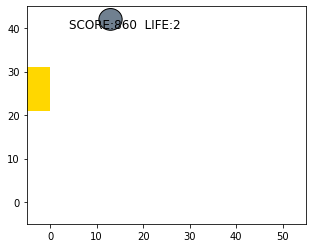

In [7]:
learner2 = Agent(game, policy=learner.get_policy())
learner2.exploitation_rate = 1.0  # Not random actions while playing
player = play(rounds=1, learner=learner2, game=game, animate=True)